<a href="https://colab.research.google.com/github/Volks44/Proj_Lab1/blob/main/4_Own_CCN_%26_AgglomerativeClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
from keras.datasets import cifar10
!pip install np_utils --quiet
import np_utils as np_utils
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import numpy as np
from matplotlib import pyplot
from keras.models import Sequential

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 856.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [ ]:
# Classes division
classes_for_clas = [0, 1, 2, 3, 4, 5]
classes_for_clus = [6,7,8,9]

# Filtering the data for classification
train_mask = np.isin(train_labels, classes_for_clas).flatten()
test_mask = np.isin(test_labels, classes_for_clas).flatten()

x_train_clas = train_images[train_mask]
y_train_clas = train_labels[train_mask]

x_test_clas = test_images[test_mask]
y_test_clas = test_labels[test_mask]

# Filtering the data for clustering
train_mask = np.isin(train_labels, classes_for_clus).flatten()
test_mask = np.isin(test_labels, classes_for_clus).flatten()

x_train_clus = train_images[train_mask]
y_train_clus = train_labels[train_mask]

x_test_clus = test_images[test_mask]
y_test_clus = test_labels[test_mask]

In [ ]:
# rescale [0,255] --> [0,1]
x_train_clas = x_train_clas.astype('float32')/255
x_test_clas = x_test_clas.astype('float32')/255

In [ ]:
x_train_clas.shape

(30000, 32, 32, 3)

In [ ]:
# one-hot encode the labels
num_classes = len(np.unique(y_train_clas))
y_train_clas = keras.utils.to_categorical(y_train_clas, num_classes)
y_test_clas = keras.utils.to_categorical(y_test_clas, num_classes)

# break training set into training and validation sets
(x_train_clas, x_valid_clas) = x_train_clas[5000:], x_train_clas[:5000]
(y_train_clas, y_valid_clas) = y_train_clas[5000:], y_train_clas[:5000]

# print shape of training set
print('x_train shape:', x_train_clas.shape)

# print number of training, validation, and test images
print(x_train_clas.shape[0], 'train samples')
print(x_test_clas.shape[0], 'test samples')
print(x_valid_clas.shape[0], 'validation samples')

x_train shape: (25000, 32, 32, 3)
25000 train samples
6000 test samples
5000 validation samples


In [ ]:
# number of hidden units variable
base_hidden_units = 32

# l2 regularization hyperparameter
weight_decay = 1e-4

model = Sequential()

# CONV1
# notice that we defined the input_shape here because this is the first CONV layer.
# we don’t need to do that for the remaining layers
model.add(Conv2D(base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train_clas.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV2
model.add(Conv2D(base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# CONV3
model.add(Conv2D(2*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV4
model.add(Conv2D(2*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# CONV5
model.add(Conv2D(4*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV6
model.add(Conv2D(4*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# FC7
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

# print model summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                       

In [ ]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
    )

# compute the data augmentation on the training set
datagen.fit(x_train_clas)

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

# training
batch_size = 64
epochs=100

checkpointer = ModelCheckpoint(filepath='model.100epochs.hdf5', verbose=1, save_best_only=True)

optimizer = Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(datagen.flow(x_train_clas, y_train_clas, batch_size=batch_size), callbacks=[checkpointer],
                steps_per_epoch=x_train_clas.shape[0] // batch_size, epochs=epochs,verbose=2,
                validation_data=(x_test_clas,y_test_clas))

Epoch 1/100

Epoch 1: val_loss improved from inf to 2.22242, saving model to model.100epochs.hdf5
390/390 - 43s - loss: 2.3922 - accuracy: 0.3474 - val_loss: 2.2224 - val_accuracy: 0.1952 - 43s/epoch - 110ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100

Epoch 2: val_loss improved from 2.22242 to 1.25822, saving model to model.100epochs.hdf5
390/390 - 16s - loss: 1.7896 - accuracy: 0.4236 - val_loss: 1.2582 - val_accuracy: 0.5205 - 16s/epoch - 41ms/step
Epoch 3/100

Epoch 3: val_loss improved from 1.25822 to 1.18496, saving model to model.100epochs.hdf5
390/390 - 16s - loss: 1.5590 - accuracy: 0.4573 - val_loss: 1.1850 - val_accuracy: 0.5435 - 16s/epoch - 42ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 1.18496
390/390 - 17s - loss: 1.4566 - accuracy: 0.4769 - val_loss: 1.2093 - val_accuracy: 0.5383 - 17s/epoch - 44ms/step
Epoch 5/100

Epoch 5: val_loss improved from 1.18496 to 1.16462, saving model to model.100epochs.hdf5
390/390 - 16s - loss: 1.4008 - accuracy: 0.4929 - val_loss: 1.1646 - val_accuracy: 0.5500 - 16s/epoch - 41ms/step
Epoch 6/100

Epoch 6: val_loss improved from 1.16462 to 1.15255, saving model to model.100epochs.hdf5
390/390 - 19s - loss: 1.3299 - accuracy: 0.5114 - val_loss: 1.1526 - val_acc

In [ ]:
model.load_weights('model.100epochs.hdf5')
scores = model.evaluate(x_test_clas, y_test_clas, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))


47/47 [==============================] - 1s 11ms/step - loss: 0.5506 - accuracy: 0.8113

Test result: 81.133 loss: 0.551


188/188 [==============================] - 1s 4ms/step


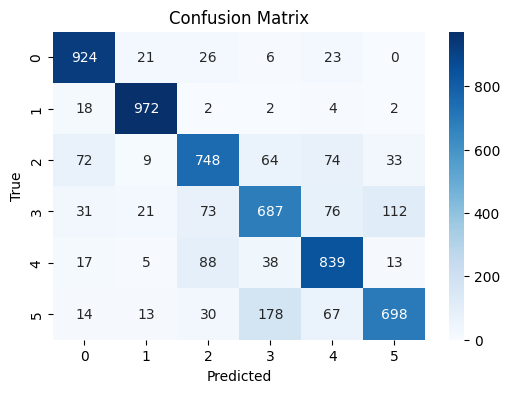


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1000
           1       0.93      0.97      0.95      1000
           2       0.77      0.75      0.76      1000
           3       0.70      0.69      0.70      1000
           4       0.77      0.84      0.81      1000
           5       0.81      0.70      0.75      1000

    accuracy                           0.81      6000
   macro avg       0.81      0.81      0.81      6000
weighted avg       0.81      0.81      0.81      6000



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

# Make predictions
predictions = model.predict(x_test_clas)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test_clas, axis=1)

# Create confusion matrix
conf_matrix_clas = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
pyplot.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_clas, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(6), yticklabels=np.arange(6))
pyplot.xlabel('Predicted')
pyplot.ylabel('True')
pyplot.title('Confusion Matrix')
pyplot.show()

# Print classification report
class_report = classification_report(true_labels, predicted_labels)
print("\nClassification Report:")
print(class_report)

Clustering

In [ ]:
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering

In [ ]:
X = x_test_clus.reshape(x_test_clus.shape[0], -1)
y = y_test_clus.reshape(-1)

In [ ]:
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30)
X_tsne = tsne.fit_transform(X)

In [ ]:
Agg = AgglomerativeClustering(n_clusters=4)
Agg.fit(X_tsne)
y_predX_tsne = Agg.fit_predict(X_tsne)


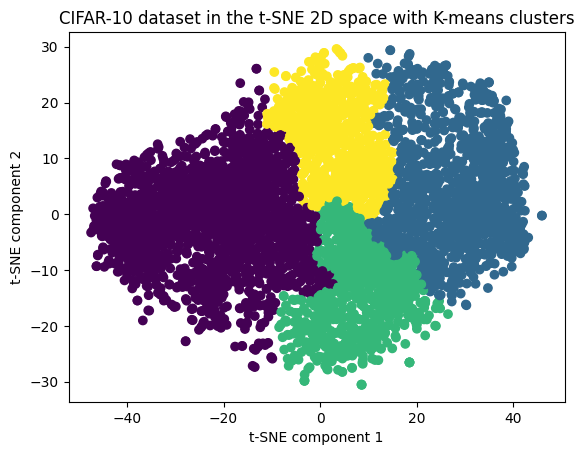

In [ ]:
pyplot.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_predX_tsne)
pyplot.xlabel('t-SNE component 1')
pyplot.ylabel('t-SNE component 2')
pyplot.title('CIFAR-10 dataset in the t-SNE 2D space with K-means clusters')
pyplot.show()

In [ ]:
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(X, y_predX_tsne)
# Calculate silhouette scores for each data point
silhouette_values = silhouette_samples(X, y_predX_tsne)

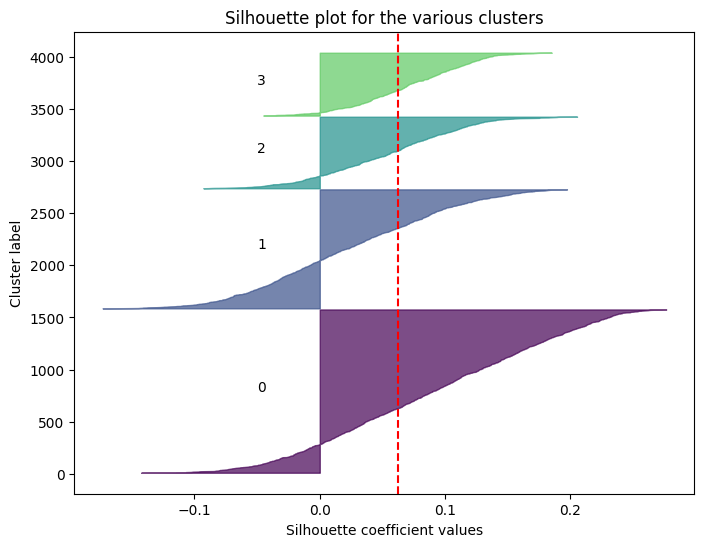

In [ ]:
# Create a bar plot
pyplot.figure(figsize=(8, 6))
y_lower = 10

for i in range(Agg.n_clusters):
    cluster_silhouette_values = silhouette_values[y_predX_tsne == i]
    cluster_silhouette_values.sort()

    size_cluster_i = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = pyplot.cm.viridis(float(i) / Agg.n_clusters)
    pyplot.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    pyplot.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for the next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

pyplot.title("Silhouette plot for the various clusters")
pyplot.xlabel("Silhouette coefficient values")
pyplot.ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
pyplot.axvline(x=silhouette_avg, color="red", linestyle="--")

pyplot.show()

In [ ]:
y_test_cm = y_test_clus.reshape(-1)
mapping = {0: 6, 1: 7, 2: 8, 3: 9}
mapped_array = np.vectorize(mapping.get)(y_predX_tsne)

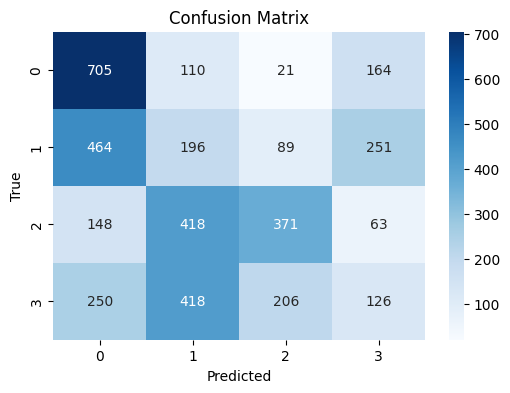


Classification Report:
              precision    recall  f1-score   support

           6       0.45      0.70      0.55      1000
           7       0.17      0.20      0.18      1000
           8       0.54      0.37      0.44      1000
           9       0.21      0.13      0.16      1000

    accuracy                           0.35      4000
   macro avg       0.34      0.35      0.33      4000
weighted avg       0.34      0.35      0.33      4000



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
predicted_labels_clus = mapped_array
true_labels = y_test_cm

# Create confusion matrix
conf_matrix_clus = confusion_matrix(true_labels, predicted_labels_clus)

# Plot the confusion matrix using seaborn
pyplot.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_clus, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(4), yticklabels=np.arange(4))
pyplot.xlabel('Predicted')
pyplot.ylabel('True')
pyplot.title('Confusion Matrix')
pyplot.show()

# Print classification report
class_report = classification_report(true_labels, predicted_labels_clus)
print("\nClassification Report:")
print(class_report)

In [ ]:
# Create a new matrix of zeros with dimensions 32x32
new_zeros = np.zeros((10, 10), dtype=int)
new_zeros[:6, :6] = conf_matrix_clas
new_zeros[6:10, 6:10] = conf_matrix_clus

<Figure size 1000x800 with 0 Axes>

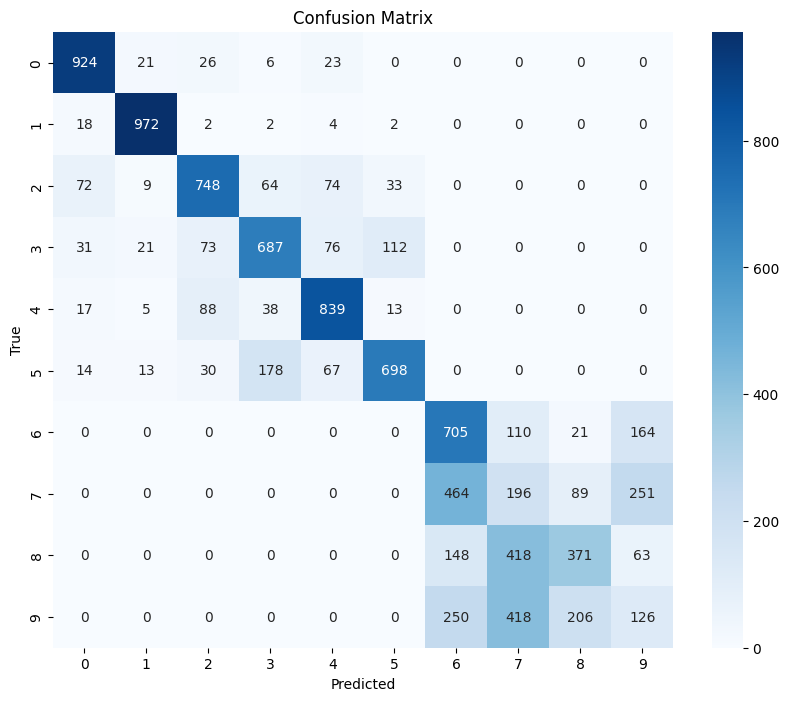

In [ ]:
# Create a figure with a specified size
pyplot.figure(figsize=(10, 8))

# Plot the combined confusion matrix
pyplot.figure(figsize=(10, 8))
sns.heatmap(new_zeros, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
pyplot.xlabel('Predicted')
pyplot.ylabel('True')
pyplot.title('Confusion Matrix')
pyplot.show()